# Technical Challenge - @Corintis - Tommaso Vandoni

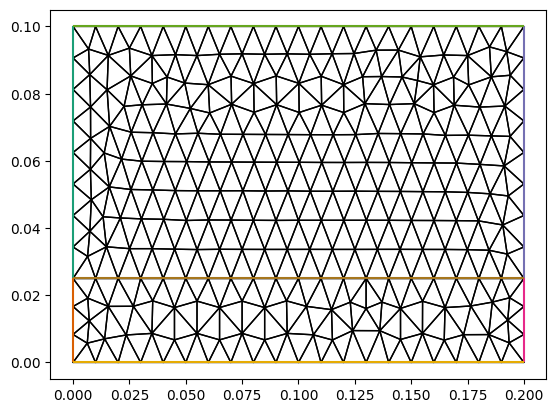

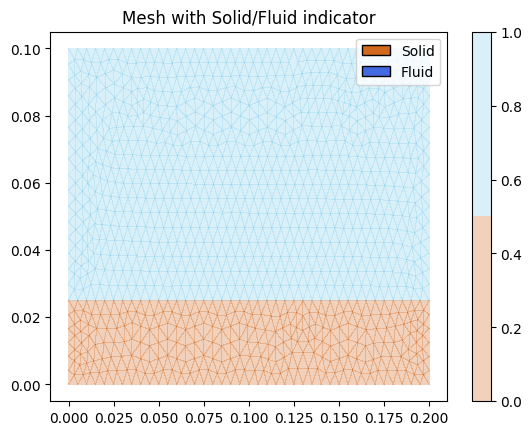

In [12]:
# Dependencies
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# Import the mesh and show it (choose other meshes modifying the path 'meshes/')
mesh = Mesh('meshes/cht-2d-rectangle.msh')
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.show()
ax.legend(loc='upper left')

# Build the chi_f indicator function from cell tags (1 in the fluid, 0 in the solid)
label = 17
M = FunctionSpace(mesh, "DG", 0)
indicator_function = Function(M)
indicator_function.assign(1, subset=mesh.cell_subset(label))

# Plot of the indicator function and the domain
cmap = ListedColormap(["chocolate", "skyblue"])
# Create a legend
legend_elements = [
    Patch(facecolor='chocolate', edgecolor='k', label='Solid'),
    Patch(facecolor='royalblue', edgecolor='k', label='Fluid')
]
fig, ax = plt.subplots()
col = tripcolor(indicator_function, axes=ax, alpha = 0.3, cmap=cmap)
plt.colorbar(col)
plt.legend(handles=legend_elements, loc='upper right')
plt.title("Mesh with Solid/Fluid indicator")
plt.show()

## Solving fluid sub-problem: steady incompressible Navier-Stokes equations

In [13]:
# Create the fluid sub mesh
relabeled_mesh = RelabeledMesh(mesh, [indicator_function], [label])
submesh = Submesh(relabeled_mesh, mesh.topological_dimension(), label)

# Function spaces (mixed formulation)
V = VectorFunctionSpace(submesh, 'P', 2)
Q = FunctionSpace(submesh, 'P', 1)
W = MixedFunctionSpace([V, Q])

# Data and Boundary Conditions 
# Different options | uncomment to select wanted dimension
# for 'cht-2d-rectangle.msh' 
L = 0.2
H = 0.075
t = 0.025
# for 'cht-2d-rectangle-slim.msh' 
# L = 0.2
# H = 0.0375
# t = 0.025

# Data of the problem
rho_f = 997
mu_f = 8.9e-4
Q_tot = (1e1)*(1e-3/60) # total flow rate
f = Constant((0.,0.))
x = SpatialCoordinate(submesh)
u_in = ((6*Q_tot)/(pow(H, 3))*(x[1]-t)*(H+t-x[1]), 0.) # Parabolic inlet with given flow rate
# Dirichlet BCs
bc_top = DirichletBC(W.sub(0), Constant((0.,0.)), 14)
bc_bottom = DirichletBC(W.sub(0), Constant((0.,0.)), 16) 
bc_in = DirichletBC(W.sub(0), u_in, 8)
bcs = (bc_top, bc_bottom, bc_in)

# Trial and Test functions
u, p = TrialFunctions(W)
v, q = TestFunctions(W)

### Initialization problem: Stokes Problem

In [14]:
# Definition of the forms involved in the Stokes initialization problem
def initialization_problem_forms(u, v, p, q, mu_f, rho_f, f):
    # Stokes initialization
    a_stokes = (2*mu_f/rho_f) * inner(sym(grad(u)),sym(grad(v))) * dx - (1/rho_f) * div(v) * p * dx + q * div(u) * dx
    L_stokes = dot(f, v) * dx
    return a_stokes, L_stokes

nsp = MixedVectorSpaceBasis(
W, [W.sub (0), VectorSpaceBasis(constant=True)]
)

# Initialization solver
wh_init = Function(W)
a_init, L_init = initialization_problem_forms(u, v, p, q, mu_f, rho_f,  f)
init_problem = LinearVariationalProblem(a_init, L_init, wh_init, bcs)
# Parameters for a direct solver
param = {'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps'}
solver_init =  LinearVariationalSolver(init_problem, solver_parameters=param, nullspace=nsp)

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


/home/tommasovandoni/firedrake/venv-firedrake/lib/python3.12/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


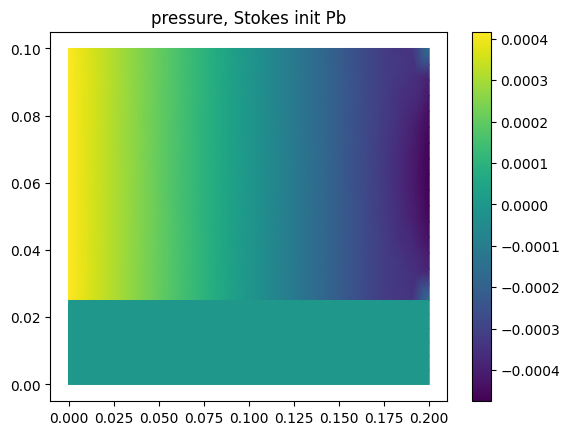

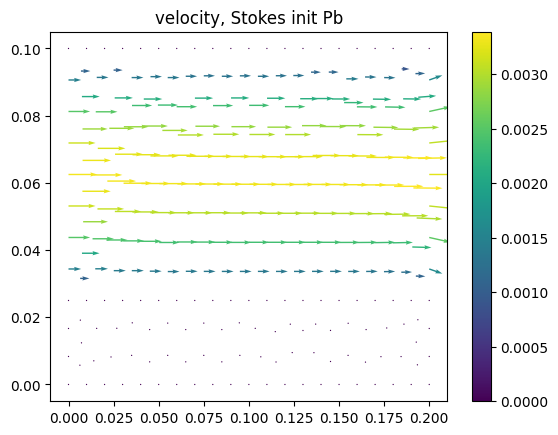

In [15]:
# Actual solution of initialization Problem
solver_init.solve()
uh_init, ph_init = wh_init.subfunctions

# Interpolation on whole mesh 

V_whole = VectorFunctionSpace(relabeled_mesh, 'P', 2)
#Q_whole = FunctionSpace(relabeled_mesh, 'P', 1)
Q_whole = FunctionSpace(relabeled_mesh, 'DG', 1) # to allow pressure drops at the interface
velocity_field_init = Function(V_whole)
pressure_field_init = Function(Q_whole)
subset = mesh.cell_subset(label)
velocity_field_init = interpolate(uh_init, V_whole, subset=subset)
pressure_field_init = interpolate(ph_init, Q_whole, subset=subset)

# Plot of initial guess (Stokes solution)
fig, ax = plt.subplots()
col = tripcolor(pressure_field_init, axes=ax)
plt.colorbar(col)
plt.title('pressure, Stokes init Pb')
plt.show()
fig, ax = plt.subplots()
col = quiver(velocity_field_init, axes=ax)
plt.colorbar(col)
plt.title('velocity, Stokes init Pb')
plt.show()

# vtk output for Paraview for the Stokes initalization Problem
outfileU_init = VTKFile("output_init_pb/velocity.pvd")
outfileP_init = VTKFile("output_init_pb/pressure.pvd")
velocity_field_init.rename("Velocity")   # this name will be used in Paraview
pressure_field_init.rename("Pressure")   # this name will be used in Paraview
outfileU_init.write(velocity_field_init)
outfileP_init.write(pressure_field_init)

### Dealing with the non linearities: Newton Method or Picard (fixed-point) iteration

In [16]:
# Definition of the forms involved in the Newton or Fixed Point (Picard) methods
def nonlinear_iteration_forms(u, v, p, q, mu_f, rho_f, f, u_old, method):
    
    if method=="newton":
        # Newton iteration
        a_Newton = (2*mu_f/rho_f) * inner(sym(grad(u)), sym(grad(v))) * dx \
        + dot(dot(grad(u), u_old), v) * dx \
        + dot(dot(grad(u_old), u), v) * dx \
        - (1/rho_f)*div(v) * p * dx \
        + q * div(u) * dx  \
        + 0.5 * div(u) * inner(u_old , v) * dx + 0.5 * div(u_old) * inner(u , v) * dx
    
        L_Newton = (1/rho_f)*dot(f, v) * dx \
        + dot(dot(grad(u_old), u_old), v) * dx \
        + 0.5 * div(u_old) * inner(u_old , v) * dx
        return a_Newton, L_Newton
    elif method=="fixed point":
        # Picard iteration
        a_Picard = (2*mu_f/rho_f) * inner(sym(grad(u)), sym(grad(v))) * dx \
        + dot(dot(grad(u), u_old), v) * dx \
        - (1/rho_f) * div(v) * p * dx \
        + 0.5 * div(u_old) * inner(u , v) * dx + q * div(u) * dx
        L_Picard = (1/rho_f) * dot(f, v) * dx 
        return a_Picard, L_Picard
    else:
        raise ValueError("Not valid expression \nAllowed options are: newton | fixed point ")  

# SUPG stabilization terms for advection dominated flows (built ad hoc for Fixed Point iteration)
def supg_forms(u, v, p, q, mu_f, rho_f, f, u_old, mesh, delta):
        #definition of the coefficient delta_k
        ubar = Function(FunctionSpace(mesh, 'DG', 0)) # piece-w lin Function, cell-wise average velocity
        ubar.project(sqrt(inner(u_old, u_old)))
        h = CellDiameter(mesh)
        nu = mu_f/rho_f
        Re_K = ubar*h/nu
        one = Constant(1.0)
        delta_K = delta * conditional(gt(Re_K, one),  h/(2*ubar+1e-5), (h*h)/(8*nu)) # piece-w lin Function because of ubar
        print(norm(delta_K), flush=True)
        # SUPG stabilization forms for Fixed Point method
        a_fp_supg = delta_K * inner( - div(2 * mu_f * sym(grad(u)) ) + rho_f * dot(grad(u) , u_old) + 0.5 * div(u_old)*u + grad(p) ,  \
                rho_f * dot(grad(v),u_old) + 0.5 * div(u_old) * v + grad(q) ) * dx \
                + delta_K * div(u) * div(v) * dx
        rhs_fp_supg = 0
        return a_fp_supg, rhs_fp_supg


In [17]:
# Nonlinear solver - initialization with the Stokes solution
u_old = Function(V)
u_old.assign(uh_init)    
p_old = Function(Q)
p_old.assign(ph_init)

# Reynodls number computation (using the Stokes velocity field):
avg_u = (1/H)*assemble(uh_init[0] * ds(8))
Re = avg_u*H*rho_f/mu_f
print("Reynodls number = ", Re)
stab = False
# default method: newton
method="newton" 
if Re > 1800:
    stab = True
    # when the non linearities are too strong: fixed point method
    method="fixed point"
    delta = 1

# Initialization of the solution and problem parameters
wh = Function(W)
uh, ph = wh.subfunctions
param = {'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps'}

#Initialization of the output files
outfileU_NS = VTKFile("output_NS/velocity.pvd")
outfileP_NS = VTKFile("output_NS/pressure.pvd")
uh.assign(u_old)
ph.assign(p_old)
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU_NS.write(uh)
outfileP_NS.write(ph)

Reynodls number =  186.70411985018723


In [18]:
# Iterative algorithm
maxit = 100
it = 0
tol = 1e-6
err = tol+1     # >tol in order to enter the loop at the beginning
print("Method:", method)
print("Using SUPG stabilization:", stab)
while it <= maxit and err > tol:
    
    it += 1
    # Non linear iteration forms for the chosen method
    a, L = nonlinear_iteration_forms(u, v, p, q, mu_f, rho_f, f, u_old, method)

    # Definition of SUPG stabilization forms for advection dominated flows
    if stab == True:
        a_supg, L_supg = supg_forms(u, v, p, q, mu_f, rho_f, f, u_old, submesh, delta)
        problem = LinearVariationalProblem(a + a_supg , L + L_supg, wh, bcs)
    else: 
        problem = LinearVariationalProblem(a , L , wh, bcs)
    solver =  LinearVariationalSolver(problem, nullspace=nsp, solver_parameters=param)
    
    solver.solve()
    uh, ph = wh.subfunctions
    
    err = (errornorm(uh, u_old, 'H1') / norm(u_old, 'H1'))
    
    print("Iteration = ", it, " Error = ", err)
    uh.rename("Velocity")
    ph.rename("Pressure")
    outfileU_NS.write(uh)
    outfileP_NS.write(ph)

    u_old.assign(uh) # update the old solution
    p_old.assign(ph) # update the old solution

if it <= maxit:
    print('Nonlinear solver converged in', it, 'iterations.')
else:
    print('Nonlinear solver di NOT converge!\nRelative error =', err, 'after', it, 'iterations.')

Method: newton
Using SUPG stabilization: False
Iteration =  1  Error =  0.10750766598214936
Iteration =  2  Error =  0.0044193907058798524
Iteration =  3  Error =  9.327397732045333e-06
Iteration =  4  Error =  4.712240325686416e-11
Nonlinear solver converged in 4 iterations.


/home/tommasovandoni/firedrake/venv-firedrake/lib/python3.12/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


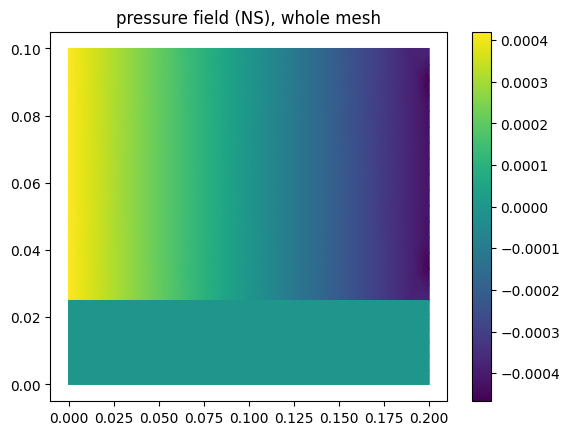

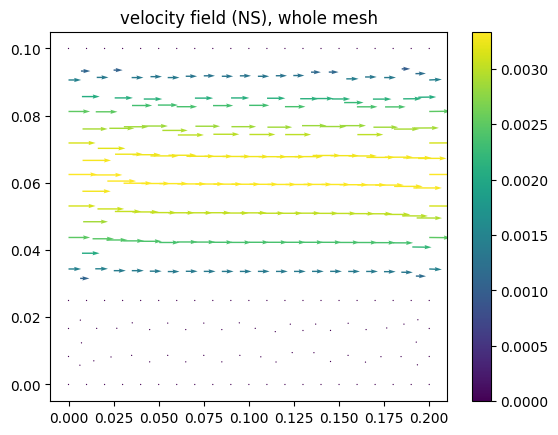

In [19]:
# Interpolation on the whole mesh 

V_whole = VectorFunctionSpace(relabeled_mesh, 'P', 2)
#Q_whole = FunctionSpace(relabeled_mesh, 'P', 1)
Q_whole = FunctionSpace(relabeled_mesh, 'DG', 1) # to allow pressure drops at the interface
velocity_field = Function(V_whole)
pressure_field = Function(Q_whole)
subset = mesh.cell_subset(label)
velocity_field_NS = interpolate(uh, V_whole, subset=subset)
pressure_field_NS = interpolate(ph, Q_whole, subset=subset)

# final plot: 

fig, ax = plt.subplots()
col = tripcolor(pressure_field_NS, axes=ax)
plt.colorbar(col)
plt.title('pressure field (NS), whole mesh')
plt.show()
fig, ax = plt.subplots()
col = quiver(velocity_field_NS, axes=ax)
plt.colorbar(col)
plt.title('velocity field (NS), whole mesh')
plt.show()

# vtk output for Paraview for the fields after interpolation on the whole mesh
# output folder contains ONLY final results
outfileU = VTKFile("output/velocity.pvd")
outfileP = VTKFile("output/pressure.pvd")
velocity_field_NS.rename("Velocity")   # this name will be used in Paraview
pressure_field_NS.rename("Pressure")   # this name will be used in Paraview
outfileU.write(velocity_field_NS)
outfileP.write(pressure_field_NS)

  

### Energy equation

Pe =  1158.1816666666666


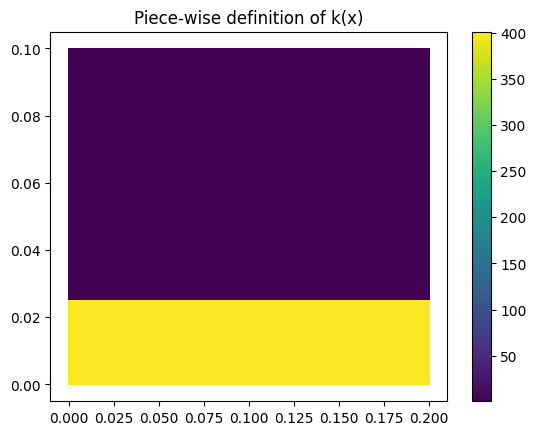

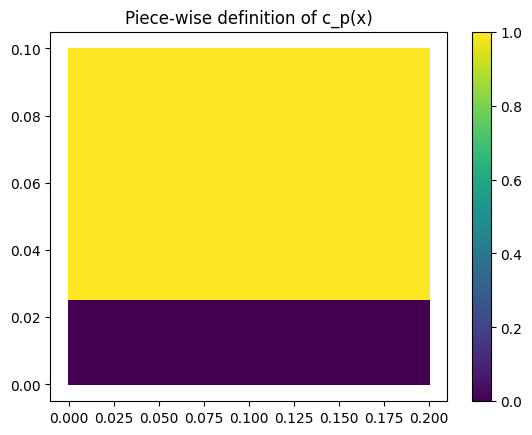

In [20]:
# Data, indicator functions for energy equations

k_f = 0.6
k_s = 401
c_p_f = 4182
q = (1e5)
neumann_tag = 15
T_in = 25+273.15

Pe = avg_u*H*rho_f*c_p_f/(k_f)
print("Pe = ", Pe)
label_f = 17
label_s = 18

M = FunctionSpace(relabeled_mesh, "DG", 0)
k_indicator_function = Function(M)
c_p_indicator_function = Function(M)
fluid_indicator_function = Function(M)

k_indicator_function.assign(k_f, subset=relabeled_mesh.cell_subset(label_f))
k_indicator_function.assign(k_s, subset=relabeled_mesh.cell_subset(label_s))
c_p_indicator_function.assign(c_p_f * rho_f, subset=relabeled_mesh.cell_subset(label_f))
fluid_indicator_function.assign(1, subset=relabeled_mesh.cell_subset(label_f))

# Plots of the piece-wise indicator functions
fig, ax = plt.subplots()
col = tripcolor(k_indicator_function, axes=ax)
plt.colorbar(col)
plt.title("Piece-wise definition of k(x)")
plt.show()
fig, ax = plt.subplots()
col = tripcolor(fluid_indicator_function, axes=ax)
plt.colorbar(col)
plt.title("Piece-wise definition of c_p(x)")
plt.show()


In [21]:
# Function spaces and definition of test and trial functions

X = FunctionSpace(relabeled_mesh, 'P', 2)
T = TrialFunction(X)
w = TestFunction(X)

# Definition of the forms involved in the Energy equation

def energy_form(rho_f, c_p_f, fluid_indicator_function, k_indicator_function, T, w, u, neumann_data, neumann_tag):

    a_energy = rho_f * c_p_f * fluid_indicator_function * dot(grad(T), u) * w * dx \
        + k_indicator_function * dot(grad(T), grad(w)) * dx
    
    L_energy = neumann_data * w * ds(neumann_tag)
    return a_energy, L_energy

def supg_energy_forms(rho_f, c_p_f, fluid_indicator_function, k_indicator_function, T, w, u, mesh, tau):

    ubar = Function(FunctionSpace(mesh, 'DG', 0)) # piece-w lin Function
    ubar.project(sqrt(inner(u, u)))
    h = CellDiameter(mesh)
    Pe_K =  h * ubar * rho_f * c_p_f / k_f # local Peclet number
    one = Constant(1.0)
    tau_k = tau * fluid_indicator_function * conditional(gt(Pe_K, one), h / (2.0*ubar + 1e-5), h*h*(rho_f*c_p_f) / (4.0*k_f))
    
    # Output the local Peclet number 
    Pe_cell_fun = Function(FunctionSpace(mesh,'DG',0))
    Pe_cell = Pe_cell_fun.project(h * ubar * rho_f * c_p_f / k_f)
    outfilePeclet = VTKFile("output_Peclet/Pe_cells.pvd")
    Pe_cell.rename("Local Peclet number")
    outfilePeclet.write(Pe_cell)

    a_energy = tau_k * (rho_f * c_p_f * fluid_indicator_function * dot(grad(T),u) - k_indicator_function * div(grad(T)) ) * \
            (rho_f * c_p_f * fluid_indicator_function * dot(grad(w),u) ) * dx

    L_energy = 0

    return a_energy, L_energy
    

Using SUPG


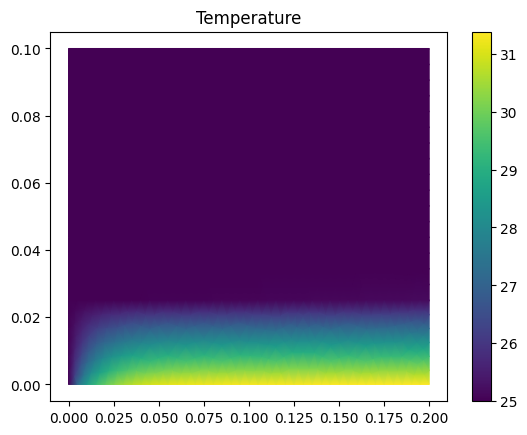

In [22]:
# Definition of the forms
tau = 1
a_energy, L_energy = energy_form(rho_f, c_p_f, fluid_indicator_function, k_indicator_function, T, w, velocity_field_NS, q, neumann_tag)
a_supg_energy, L_supg_energy = supg_energy_forms(rho_f, c_p_f, fluid_indicator_function, k_indicator_function, T, w, velocity_field_NS, relabeled_mesh, tau)

T_h = Function(X)

# BCs
bc_in_energy = DirichletBC(X, T_in, (8,9))
bcs_energy = (bc_in_energy)
stab_energy = True
if stab_energy == True:
    print("Using SUPG")
    energy_Pb = LinearVariationalProblem(a_energy + a_supg_energy, L_energy + L_supg_energy, T_h, bcs_energy)
else:
    energy_Pb = LinearVariationalProblem(a_energy, L_energy, T_h, bcs_energy)

param = {'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps'}
energy_solver = LinearVariationalSolver(energy_Pb, solver_parameters = param)

energy_solver.solve()
T_h -= 273.15
# Plot of the temperature
fig, ax = plt.subplots()
col = tripcolor(T_h, axes=ax)
plt.colorbar(col)
plt.title('Temperature')
plt.show()

# vtk output for Paraview 
outfileT = VTKFile("output/temperature.pvd")
T_h.rename("Temperature")   # this name will be used in Paraview
outfileT.write(T_h)

